In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import *
import pandas as pd
import glob
import joblib
import base64
from sklearn.cluster import KMeans
import pickle
import joblib
from joblib import dump, load
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Пример работы SIFT

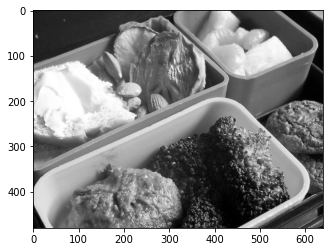

In [ ]:
#выделить ключевые точки на изображении
#img = cv.imread('drive/MyDrive/Images/img2.jpg',cv2.IMREAD_COLOR)
img = cv.imread('img2.jpg',cv.IMREAD_COLOR)
img1 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img1, 'gray');
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(img1, None)
img_res=cv.drawKeypoints(img1,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv2.imwrite('sift_keypoints.jpg',img)

#print(des)

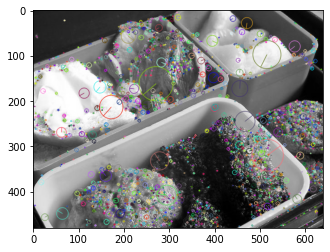

In [ ]:
#det = cv2.imread('sift_keypoints.jpg',cv2.IMREAD_COLOR)
img1 = cv.cvtColor(img_res, cv.COLOR_BGR2RGB)
plt.imshow(img1, 'gray');

# Шаг 1. Подключение к Kaggle

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterinanovikova","key":"197254b79a634fac5f7d1bfdab40f0fc"}'}

In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ultralytics/coco128

100% 6.66M/6.66M [00:01<00:00, 8.43MB/s]
100% 6.66M/6.66M [00:01<00:00, 5.21MB/s]


In [ ]:
!ls

coco128.zip  drive  kaggle.json  sample_data


In [ ]:
!unzip coco128.zip

Archive:  coco128.zip
  inflating: coco128/LICENSE         
  inflating: coco128/README.txt      
  inflating: coco128/images/train2017/000000000009.jpg  
  inflating: coco128/images/train2017/000000000025.jpg  
  inflating: coco128/images/train2017/000000000030.jpg  
  inflating: coco128/images/train2017/000000000034.jpg  
  inflating: coco128/images/train2017/000000000036.jpg  
  inflating: coco128/images/train2017/000000000042.jpg  
  inflating: coco128/images/train2017/000000000049.jpg  
  inflating: coco128/images/train2017/000000000061.jpg  
  inflating: coco128/images/train2017/000000000064.jpg  
  inflating: coco128/images/train2017/000000000071.jpg  
  inflating: coco128/images/train2017/000000000072.jpg  
  inflating: coco128/images/train2017/000000000073.jpg  
  inflating: coco128/images/train2017/000000000074.jpg  
  inflating: coco128/images/train2017/000000000077.jpg  
  inflating: coco128/images/train2017/000000000078.jpg  
  inflating: coco128/images/train2017/000000000

In [ ]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls

coco128  coco128.zip  drive  kaggle.json  sample_data


# Шаг 2. Создание базы дескрипторов

In [ ]:
#path - /content/coco128/images/train2017
def getDescriptorsFromBase(path):
  descriptors = np.empty((0,128))
  k = 0
  for i in glob.glob(path):
    #print(i)
    imgg = cv.imread(i)
    gray = cv.cvtColor(imgg, cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    _, des = sift.detectAndCompute(gray, None)
    descriptors = np.append(descriptors, des, axis = 0)
    k += 1
  return descriptors

In [ ]:
descr = getDescriptorsFromBase('/content/coco128/images/train2017/*')

In [ ]:
descr.shape

(186062, 128)

# Шаг 3.1. 

In [ ]:
import torch
from torchvision.models import resnet50
from tqdm import tqdm

def preprocessing(img):
  return torch.FloatTensor(cv.resize(img, 224, 224))

In [ ]:
def preprocessing2(img):
  return torch.FloatTensor(cv.resize(img, (224, 224))).permute(2, 0, 1).unsqueeze(0) / 255.

In [ ]:
def neiron_emb(img_path, model):
  img = cv.imread(img_path, cv.IMREAD_COLOR)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  inp = preprocessing2(img)
  with torch.no_grad():
      out = model(inp)
  emb = out[0].numpy()
  return emb

# Шаг 4.1. Загрузка 2 датасета

Всего в датасете 5к картинок, возьмем первые 2к (потому что иначе не потянет(()

In [ ]:
!kaggle datasets download -d awsaf49/coco-2017-dataset

100% 25.0G/25.0G [18:40<00:00, 25.2MB/s]
100% 25.0G/25.0G [18:40<00:00, 24.0MB/s]


In [ ]:
!unzip coco-2017-dataset.zip

# Шаг 4-5. Функция для представления изображения в виде вектора в метрическом пространстве + сохранение в таблицу

In [ ]:
def getEmbeddings(path):
  embeddings = []
  paths = []
  model = resnet50(True)
  model = model.eval()
  for i in tqdm(glob.glob(path)):
    img_path = i[22:]
    paths.append(img_path)
    e = neiron_emb(i, model)
    embeddings.append(base64.b64encode(e))
  embedBase = {'path': paths, 'embed': embeddings}
  embedBaseDf = pd.DataFrame(data=embedBase)
  embedBaseDf.to_csv('embedBaseDf11.csv',index=False)
  return embedBaseDf

In [ ]:
embedBaseDf = getEmbeddings('/content/drive/MyDrive/val2017/*')

100%|██████████| 2000/2000 [04:54<00:00,  6.79it/s]


In [1]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 761 kB 30.6 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=89e39e83316f69fba4799903eda166316d343c3dffd13b3a550e948063035e84
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok


In [3]:
!pip install jupyter-dash
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output# Load Data
df = px.data.tips()# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("1littlecoder deploy ML App Colab ngrok Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )# Run app and display result inline in the notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 44.0 MB/s 
     |████████████████████████████████| 1.6 MB 59.6 MB/s 


<ipython-input-3-b6d1cad0d4db>:4: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-3-b6d1cad0d4db>:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [13]:
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [11]:
from pyngrok import ngrok
# Open a HTTP tunnel on the default port 80
public_url = ngrok.connect(port = '8050')

In [14]:
public_url

<NgrokTunnel: "http://30cd-34-145-169-150.ngrok.io" -> "http://localhost:80">